In [5]:
import xarray as xr

file_path =r'../data/7/NL16_10km_5min.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 9GB
Dimensions:  (time: 1753153, i: 37, j: 35)
Coordinates:
    lon      (i, j) float32 5kB ...
    lat      (i, j) float32 5kB ...
  * time     (time) datetime64[ns] 14MB 2007-12-31T23:55:00 ... 2024-08-31T07...
  * i        (i) int16 74B 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35 36
  * j        (j) int16 70B 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33 34
Data variables:
    Pr       (time, i, j) float32 9GB ...
Attributes:
    title:        Gridded NL Precipitation Data
    description:  Precipitation data from original 1x1km grid coarsened to a ...

In [9]:
z_obs = ds['Pr'].values
ts = z_obs[:, 10, 10]

In [10]:
z_obs.shape

(1753153, 37, 35)

In [11]:
ts = z_obs[:, 10, 10]

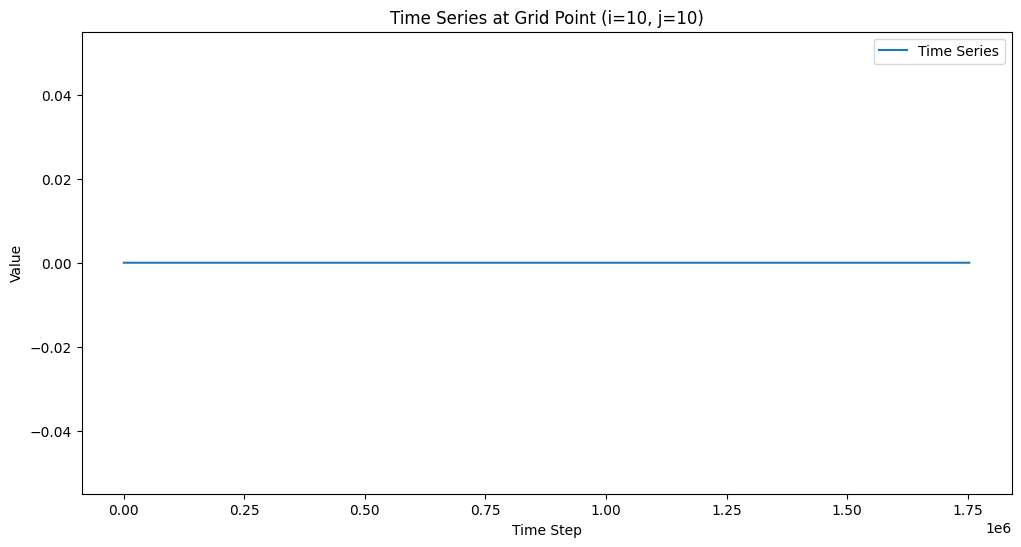

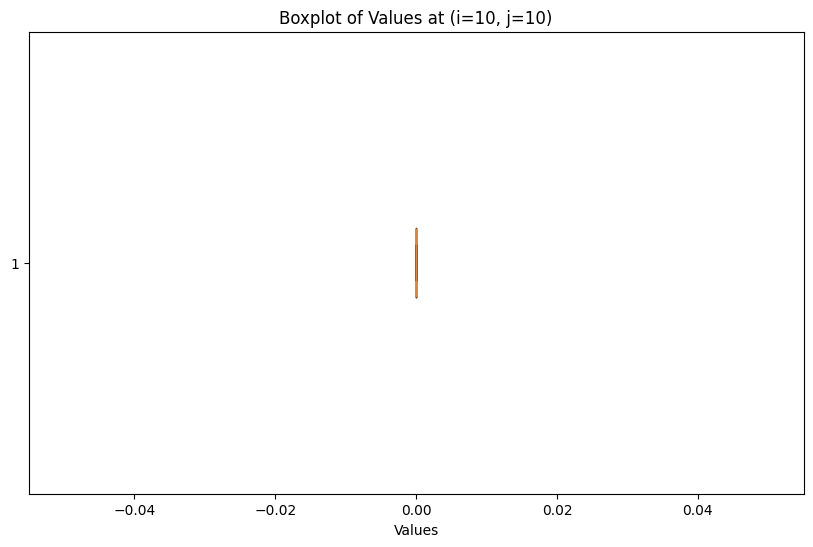

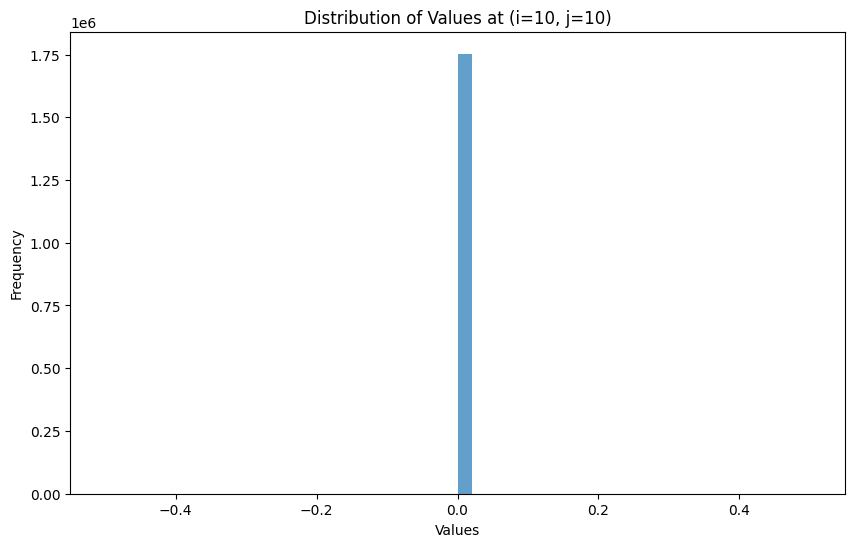

In [14]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Time Series')
plt.title('Time Series at Grid Point (i=10, j=10)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Create a boxplot of the time series data
plt.figure(figsize=(10, 6))
plt.boxplot(ts, vert=False)
plt.title('Boxplot of Values at (i=10, j=10)')
plt.xlabel('Values')
plt.show()

# Plot the distribution of values using a histogram
plt.figure(figsize=(10, 6))
plt.hist(ts, bins=50, alpha=0.7)
plt.title('Distribution of Values at (i=10, j=10)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

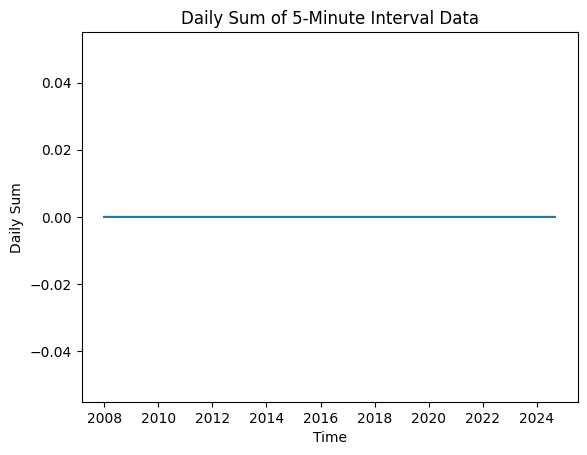

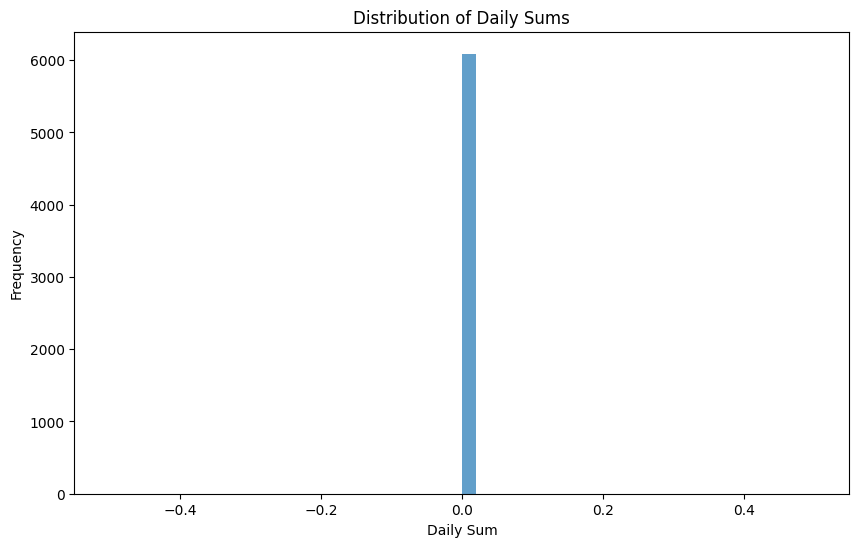

In [15]:
import matplotlib.pyplot as plt

# Sum daily values for the specified variable at location (i=10, j=10)
var = 'Pr'
ts = ds[var].sel(i=10, j=10)

# Resample to daily frequency by summing 5-minute intervals
daily_sum = ts.resample(time='1D').sum()

# Plot the time series of daily sums
daily_sum.plot()
plt.title('Daily Sum of 5-Minute Interval Data')
plt.ylabel('Daily Sum')
plt.xlabel('Time')
plt.show()

# # Create boxplot of daily sums
# plt.figure(figsize=(10, 6))
# daily_sum.plot.box()
# plt.title('Boxplot of Daily Sums')
# plt.ylabel('Daily Sum')
# plt.show()

# Plot distribution of daily sums
plt.figure(figsize=(10, 6))
daily_sum.plot.hist(bins=50, alpha=0.7)
plt.title('Distribution of Daily Sums')
plt.xlabel('Daily Sum')
plt.ylabel('Frequency')
plt.show()

In [35]:
import xarray as xr
import os

# Step 1: Set directory path
directory = r'C:\Users\reverd\OneDrive - SAS\Documents\Thesis\4. Data\2. Meteorological\Precipitation\processed\nl26_2_4km_5min'

# Step 2: Get list of all files in the 'year/month' subdirectories
files = []
for year in os.listdir(directory):
    month_path = os.path.join(directory, year)
    # print(month_path)
    if os.path.isfile(month_path) and month_path.endswith('.nc'):
        files.append(month_path)
        # for month in os.listdir(year_path):
        #     month_path = os.path.join(year_path, month)
        #     print(month_path)
        #     if os.path.isfile(month_path) and month_path.endswith('.nc'):
        #         files.append(month_path)
print(files)
# Step 3: Sort the files to ensure chronological order
files.sort()  # Sort to ensure files are in chronological order

# # Step 4: Use xarray to open and concatenate the NetCDF files
# combined_ds = xr.open_mfdataset(files, concat_dim='time', combine='by_coords')
# combined_ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')#, parallel=True)
combined_ds_concat = xr.concat([xr.open_dataset(f) for f in files], dim='time')
# Sort the time index to ensure it's monotonic
combined_ds_concat = combined_ds_concat.sortby('time')
# # # Step 5: Save the concatenated dataset to a new NetCDF file
# output_path =r'../test/NL16_2_4km_5min_2001.nc'
# # combined_ds.to_netcdf(output_path)
# combined_ds.to_netcdf(output_path, engine='h5netcdf', encoding={
#     'lon': {'dtype': 'float32', 'zlib': True, 'complevel': 5, 'shuffle': True},
#     'lat': {'dtype': 'float32', 'zlib': True, 'complevel': 5, 'shuffle': True},
#     'i':   {'dtype': 'int16',   'zlib': True, 'complevel': 5, 'shuffle': True},
#     'j':   {'dtype': 'int16',   'zlib': True, 'complevel': 5, 'shuffle': True},
#     'Pr':  {'dtype': 'float32', 'zlib': True, 'complevel': 5, 'shuffle': True}
# })
# print("Files successfully concatenated into combined_rainfall_data.nc")

['C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200101.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200102.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200103.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200104.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200105.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Meteorological\\Precipitation\\processed\\nl26_2_4km_5min\\RAD_NL2_4km_5min_200106.nc', 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\4. Data\\2. Me

In [27]:
combined_ds_concat

<xarray.Dataset> Size: 7GB
Dimensions:      (time: 105120, i: 150, j: 110)
Coordinates:
    lon          (j) float32 440B 3.475 3.511 3.548 3.585 ... 7.377 7.413 7.449
    lat          (i) float32 600B 53.8 53.78 53.76 53.74 ... 50.64 50.62 50.6
  * time         (time) datetime64[ns] 841kB 2001-01-01T00:30:00 ... 2001-12-...
  * i            (i) int16 300B 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * j            (j) int16 220B 0 1 2 3 4 5 6 7 ... 103 104 105 106 107 108 109
    spatial_ref  int64 8B 0
Data variables:
    Pr           (time, i, j) float32 7GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:        Gridded NL Precipitation Data
    description:  Precipitation data from original 2.4km spatial resolution g...

In [29]:
z_obs_concat = combined_ds_concat['Pr'].values

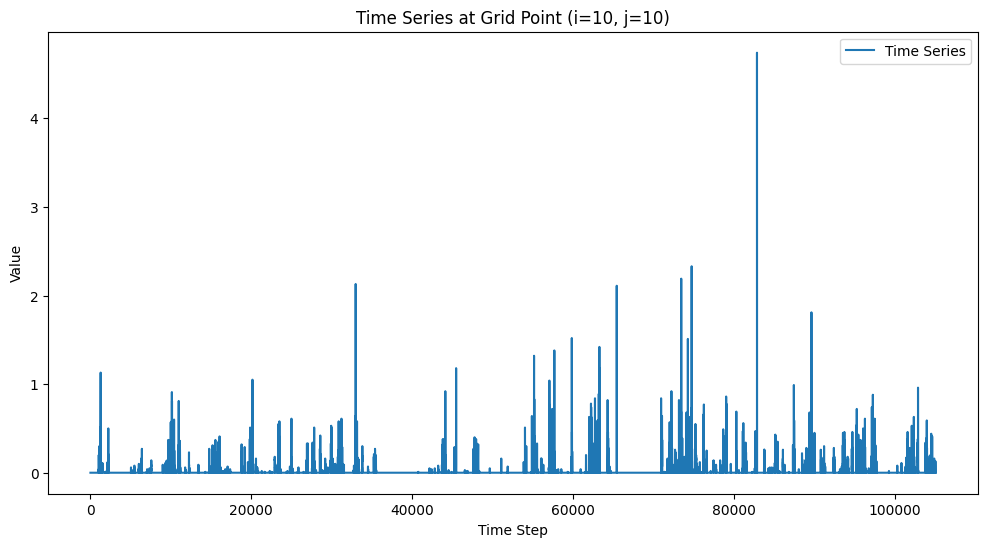

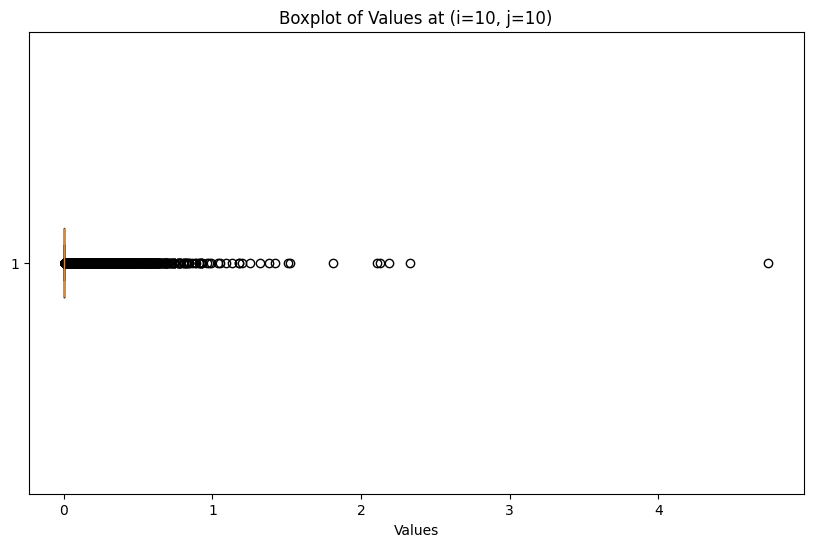

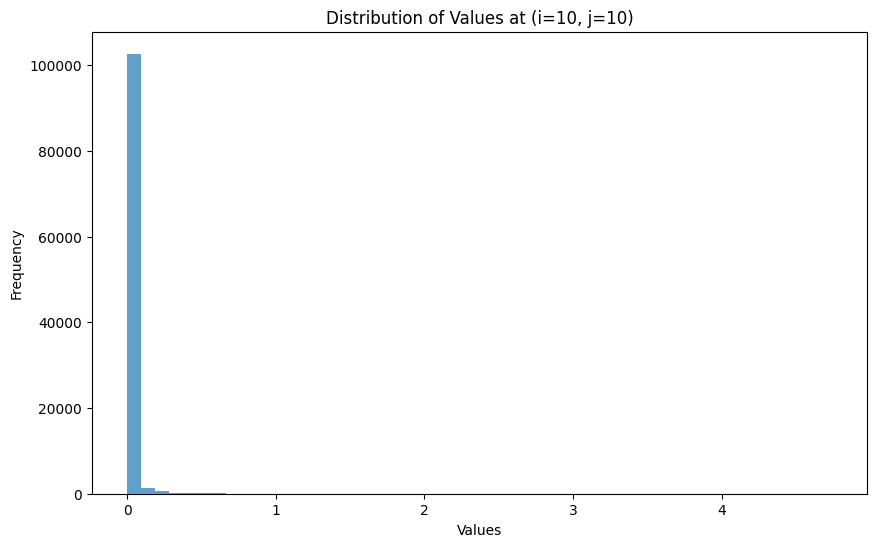

In [33]:
ts = z_obs_concat[:, 50, 50]
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Time Series')
plt.title('Time Series at Grid Point (i=10, j=10)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Create a boxplot of the time series data
plt.figure(figsize=(10, 6))
plt.boxplot(ts, vert=False)
plt.title('Boxplot of Values at (i=10, j=10)')
plt.xlabel('Values')
plt.show()

# Plot the distribution of values using a histogram
plt.figure(figsize=(10, 6))
plt.hist(ts, bins=50, alpha=0.7)
plt.title('Distribution of Values at (i=10, j=10)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

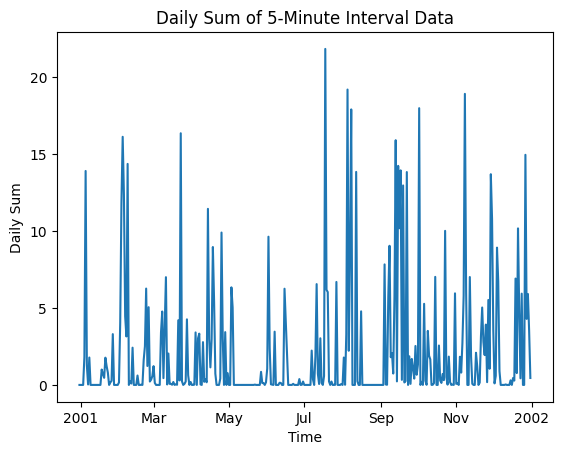

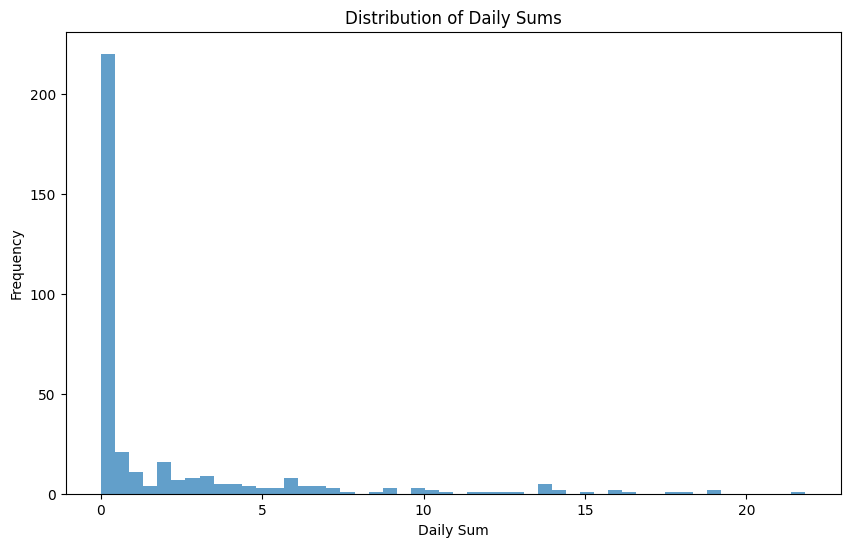

In [36]:
# Sum daily values for the specified variable at location (i=10, j=10)
var = 'Pr'
ts = combined_ds_concat[var].sel(i=50, j=50)

# Resample to daily frequency by summing 5-minute intervals
daily_sum = ts.resample(time='1D').sum()

# Plot the time series of daily sums
daily_sum.plot()
plt.title('Daily Sum of Daily Interval Data')
plt.ylabel('Daily Sum')
plt.xlabel('Time')
plt.show()

# # Create boxplot of daily sums
# plt.figure(figsize=(10, 6))
# daily_sum.plot.box()
# plt.title('Boxplot of Daily Sums')
# plt.ylabel('Daily Sum')
# plt.show()

# Plot distribution of daily sums
plt.figure(figsize=(10, 6))
daily_sum.plot.hist(bins=50, alpha=0.7)
plt.title('Distribution of Daily Sums')
plt.xlabel('Daily Sum')
plt.ylabel('Frequency')
plt.show()

In [37]:
ds_hourly = combined_ds_concat.resample(time='1h').sum()

# Check the results
print(ds_hourly)

c:\Users\reverd\OneDrive - SAS\Documents\Thesis\3. Code\2. Modelling\Hazard\Spatial extremes\spatial-extremes\.venv\Lib\site-packages\xarray\groupers.py:403: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 578MB
Dimensions:      (time: 8761, i: 150, j: 110)
Coordinates:
    lon          (j) float32 440B 3.475 3.511 3.548 3.585 ... 7.377 7.413 7.449
    lat          (i) float32 600B 53.8 53.78 53.76 53.74 ... 50.64 50.62 50.6
  * i            (i) int16 300B 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * j            (j) int16 220B 0 1 2 3 4 5 6 7 ... 103 104 105 106 107 108 109
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 70kB 2000-12-31T23:00:00 ... 2001-12-3...
Data variables:
    Pr           (time, i, j) float32 578MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:        Gridded NL Precipitation Data
    description:  Precipitation data from original 2.4km spatial resolution g...


In [38]:
# Step 2: Coarsen the grid by a factor of 4
# Assuming dimensions 'i' and 'j' are the spatial dimensions
ds_coarsened = ds_hourly.coarsen(i=4, j=4, boundary='trim').sum()

# Check the results
print(ds_coarsened)

<xarray.Dataset> Size: 35MB
Dimensions:      (time: 8761, i: 37, j: 27)
Coordinates:
    lon          (j) float32 108B 3.53 3.676 3.823 3.969 ... 7.033 7.178 7.322
    lat          (i) float32 148B 53.77 53.68 53.6 53.51 ... 50.84 50.76 50.67
  * i            (i) float64 296B 1.5 5.5 9.5 13.5 ... 133.5 137.5 141.5 145.5
  * j            (j) float64 216B 1.5 5.5 9.5 13.5 ... 93.5 97.5 101.5 105.5
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 70kB 2000-12-31T23:00:00 ... 2001-12-3...
Data variables:
    Pr           (time, i, j) float32 35MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:        Gridded NL Precipitation Data
    description:  Precipitation data from original 2.4km spatial resolution g...


In [40]:
import geopandas as gpd
file_path =  r'C:\Users\reverd\OneDrive - SAS\Documents\Thesis\4. Data\Other\NL_provincie_multipolygon.gpkg'
gdf = gpd.read_file(file_path)
gdf = gdf.to_crs(epsg=4326)
gdf = gdf[['PROVINCIE' , 'geometry']]

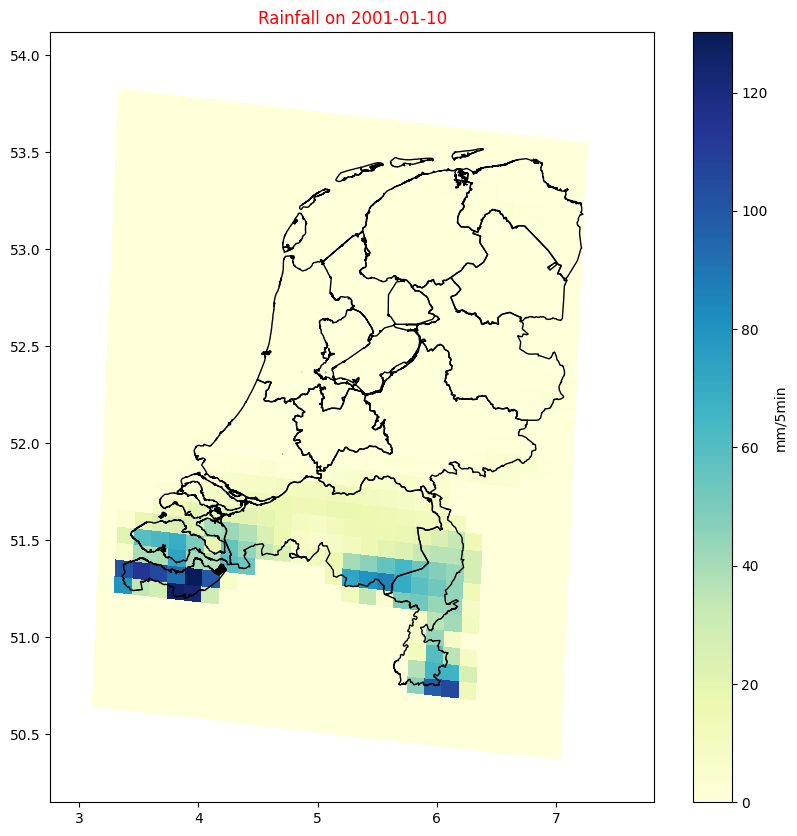

In [46]:
import numpy as np
# Updated plot_daily_precipitation function with manual alignment adjustments and rotation
def plot_daily_precipitation(ds: xr.Dataset, var: str, date: str, gdf: gpd.GeoDataFrame, buffer_deg=0.2, lon_offset=0.0, lat_offset=0.0, rotation_angle=0.0):
    """
    Plot the daily precipitation data over the Netherlands for a specific date with alignment and rotation adjustments.
    
    Args:
        ds (xr.Dataset): The dataset containing the precipitation data.
        var (str): The variable name to plot.
        date (str): The date to plot in 'YYYY-MM-DD' format.
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the multipolygon boundaries of the area of interest.
        buffer_deg (float): Buffer in degrees to extend the plotting area around the boundary.
        lon_offset (float): Manual offset in degrees to adjust the longitude alignment.
        lat_offset (float): Manual offset in degrees to adjust the latitude alignment.
        rotation_angle (float): Rotation angle in degrees to rotate the precipitation data.
    """
    # Ensure the GeoDataFrame is in the correct CRS (EPSG:4326)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)

    # Check if dataset lat/lon values fall within the GeoDataFrame boundaries
    ds_lon = ds['lon'].values
    ds_lat = ds['lat'].values

    # Reverse the order of the latitude and longitude values if needed
    if ds_lat[0] > ds_lat[-1]:
        ds = ds.sortby('lat')  # Ensure latitude is in ascending order

    if ds_lon[0] > ds_lon[-1]:
        ds = ds.sortby('lon')  # Ensure longitude is in ascending order

    # Resample the data to daily intervals, summing over each day
    daily_sum = ds[var].resample(time='1D').sum()

    # Convert the input date to a numpy datetime64 format to match dataset format
    target_date = np.datetime64(date)

    # Check if the specified date exists in the dataset
    if target_date not in daily_sum['time'].values:
        print(f"Date {target_date} not found in the dataset.")
        return

    # Extract data for the specific date
    daily_data = daily_sum.sel(time=target_date)

    # Check the shape of the data to ensure it matches the grid
    if daily_data.ndim == 3:
        # Extract the 2D data for the specified date
        daily_data_2d = daily_data[0, :, :]
    elif daily_data.ndim == 2:
        # Data is already 2D
        daily_data_2d = daily_data
    else:
        raise ValueError("Unexpected data dimensions for plotting.")

    # Create the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Correct for potential misalignment by adjusting lon/lat grid
    lon_2d, lat_2d = np.meshgrid(ds['lon'].values, ds['lat'].values)
    lon_res = (ds['lon'].values[1] - ds['lon'].values[0]) / 2.0
    lat_res = (ds['lat'].values[1] - ds['lat'].values[0]) / 2.0
    lon_2d -= lon_res
    lat_2d -= lat_res

    # Apply manual offsets for alignment correction
    lon_2d += lon_offset
    lat_2d += lat_offset

    # Rotation adjustment (rotate around the center of the grid)
    if rotation_angle != 0.0:
        # Convert rotation angle to radians
        theta = np.radians(rotation_angle)
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)

        # Calculate the center of the grid
        lon_center = np.mean(lon_2d)
        lat_center = np.mean(lat_2d)

        # Shift the grid to the origin
        lon_shifted = lon_2d - lon_center
        lat_shifted = lat_2d - lat_center

        # Apply rotation matrix
        lon_rotated = lon_shifted * cos_theta - lat_shifted * sin_theta
        lat_rotated = lon_shifted * sin_theta + lat_shifted * cos_theta

        # Shift back to the original center
        lon_2d = lon_rotated + lon_center
        lat_2d = lat_rotated + lat_center

    # Use pcolormesh for proper geospatial plotting
    pcm = ax.pcolormesh(lon_2d, lat_2d, daily_data_2d, cmap='YlGnBu')

    # Plot the GeoDataFrame boundaries
    gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

    # Add colorbar
    cbar = fig.colorbar(pcm, ax=ax, label=daily_data.units)

    # Set the extent to focus on the area of interest using GeoDataFrame bounds plus a buffer
    min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
    ax.set_xlim([min_lon - buffer_deg, max_lon + buffer_deg])
    ax.set_ylim([min_lat - buffer_deg, max_lat + buffer_deg])

    # Set title
    ax.set_title(f'Rainfall on {date}', loc='center', color='r')

    # Show the plot
    plt.show()


"""
buffer_deg :    Increases the plot area around the boundary. Higher values extend the view.
lon_offset :    Shifts the precipitation data left (negative) or right (positive) in degrees.
lat_offset :    Shifts the precipitation data down (negative) or up (positive) in degrees.
rotation_angle : Rotates the precipitation data. Positive values rotate counterclockwise, negative values rotate clockwise.
"""


# Example usage
plot_daily_precipitation(ds_coarsened, var='Pr', date='2001-01-10', gdf=gdf, rotation_angle=-4, buffer_deg=0.6, lon_offset=-0.17, lat_offset=-0.08)

In [47]:
Z_obs = ds_coarsened['Pr'].values

In [55]:
import numpy as np
import xarray as xr
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import genpareto
from tqdm import tqdm
import logging

logger = logging.getLogger(__name__)


##################################################################

EXPERIMENT = 1

if EXPERIMENT == 1:
    dataset = 'precipitation_maxima'
elif EXPERIMENT == 2:
    dataset = 'NL26_2km_5min'
elif EXPERIMENT == 3:
    dataset = 'NL26_10km_24h'


##################################################################

logger = logging.getLogger(__name__)

def fit_gpd_to_grid_point(time_series, threshold):
    """
    Fit the GPD distribution to a single grid point time series above a given threshold.
    """
    # Filter data above the threshold
    exceedances = time_series[time_series > threshold] - threshold
    
    if len(exceedances) < 1:
        return np.nan, np.nan, np.nan
    
    try:
        # Fit the GPD distribution to the exceedances using MLE
        shape, loc, scale = genpareto.fit(exceedances)
        return shape, loc + threshold, scale
    except Exception as e:
        logger.warning(f"Could not fit GPD to time series: {e}")
        return np.nan, np.nan, np.nan

def fit_gpd_margins(obs: np.ndarray, threshold: float, output_file_path: str) -> np.ndarray:
    """
    Fit GPD distribution to each grid point of the input data in parallel.

    Parameters:
    - obs: A 3D numpy array with dimensions (time, lat, lon)
    - threshold: Threshold value for fitting GPD
    - output_file_path: Path to the file where GPD parameters will be saved

    Returns:
    - GPD_params: A 3D numpy array of shape (lat, lon, 3) containing fitted GPD parameters
    """
    n_lat, n_lon = obs.shape[1], obs.shape[2]
    GPD_params = np.zeros((n_lat, n_lon, 3))

    # Flatten the grid indices for easier parallel processing
    indices = [(i, j) for i in range(n_lat) for j in range(n_lon)]

    # Define a helper function to fit GPD for a single grid point and update results
    def process_grid_point(index):
        i, j = index
        time_series = obs[:, i, j]
        shape, loc, scale = fit_gpd_to_grid_point(time_series, threshold)
        return (i, j, shape, loc, scale)

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        # Wrap the executor.map call with tqdm for progress tracking
        results = list(tqdm(executor.map(process_grid_point, indices), total=len(indices), desc="Fitting GPD"))

    # Save results to the GPD_params array
    for i, j, shape, loc, scale in results:
        GPD_params[i, j, 0] = shape
        GPD_params[i, j, 1] = loc
        GPD_params[i, j, 2] = scale

    # Save GPD parameters to file
    with open(output_file_path, 'w') as file:
        for i, j, shape, loc, scale in results:
            if not np.isnan(shape):
                print(f"GPD fitted to grid point ({i}, {j}): shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
                file.write(f"({i+1}, {j+1}): {shape:.4f}, {loc:.4f}, {scale:.4f}\n")


# Define a threshold for GPD fitting (adjust based on your analysis needs)
threshold = 0.01  # Example threshold value

fp = f'.data\{EXPERIMENT}\{dataset}.nc'

fp = f'..\data\\1\\precipitation_maxima.nc'
ds = xr.open_dataset(fp)
var_name = list(ds.data_vars)[0]
Z_obs = ds[var_name].values

file_path = r'C:\Users\reverd\OneDrive - SAS\Documents\Thesis\3. Code\2. Modelling\Hazard\Spatial extremes\spatial-extremes\experiments\params\GPD_params.txt'
fit_gpd_margins(Z_obs, threshold, file_path)

Fitting GPD: 100%|██████████| 396/396 [01:02<00:00,  6.31it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\reverd\\OneDrive - SAS\\Documents\\Thesis\\3. Code\\2. Modelling\\Hazard\\Spatial extremes\\spatial-extremes\\experiments\\params\\GPD_params.txt'